In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA


In [2]:
feature_names = pd.read_csv('feature_names.csv', header=None)
kdd_names = feature_names.iloc[:,0].values
kdd = pd.read_csv('kddcup.data_10_percent_corrected.csv', names=kdd_names)

#kdd1 = kdd.sample(frac=0.5, random_state=42)
#kdd2 = kdd.drop(kdd1.index)

#kdd = kdd1.copy()


In [3]:
for i in range(len(kdd.columns)):
    if kdd.dtypes[i] == object:
        print(kdd.columns[i],end =": ")
        print(kdd[kdd.columns[i]].unique())

protocol_type: ['tcp' 'udp' 'icmp']
service: ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
flag: ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
attack_type: ['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']


In [4]:
kdd_multiclass = kdd.copy()
dos   = ['neptune.', 'land.', 'pod.', 'smurf.', 'teardrop.', 'back.', 'worm.', 'udpstorm.', 'processtable.', 'apache2.']
probe = ['ipsweep.','satan.','nmap.','portsweep.','mscan.','saint.']
R2L   = ['ftp_write.','guess_passwd.', 'imap.','multihop.','phf.'
         ,'spy.','warezclient.','warezmaster.','snmpguess.','named.','xlock.','snmpgetattack.','httptunnel.','sendmail.']
U2R   = ['buffer_overflow.','loadmodule.','perl.','rootkit.','ps.','xterm.','sqlattack.']

kdd_multiclass['attack_type'].values[kdd_multiclass['attack_type'].isin(dos)] = 'dos'
kdd_multiclass['attack_type'].values[kdd_multiclass['attack_type'].isin(probe)] = 'probe'
kdd_multiclass['attack_type'].values[kdd_multiclass['attack_type'].isin(R2L)] = 'R2L'
kdd_multiclass['attack_type'].values[kdd_multiclass['attack_type'].isin(U2R)] = 'U2R'

In [5]:
for i in range(len(kdd_multiclass.columns)):
    if kdd_multiclass.dtypes[i] == object:
        print(kdd_multiclass.columns[i],end =": ")
        print(kdd_multiclass[kdd_multiclass.columns[i]].unique())

protocol_type: ['tcp' 'udp' 'icmp']
service: ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
flag: ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
attack_type: ['normal.' 'U2R' 'dos' 'R2L' 'probe']


In [6]:
kdd_multi_encoded = pd.get_dummies(kdd_multiclass, columns=['protocol_type','flag','service'])
kdd_multi_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Columns: 119 entries, duration to service_whois
dtypes: float64(15), int64(23), object(1), uint8(80)
memory usage: 184.7+ MB


In [8]:
#kdd_multiclass.info()

In [9]:
#kdd_multi_encoded.head()
#kdd_multi_encoded.info()

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(kdd_multi_encoded.drop(labels=['attack_type'], axis=1),
    kdd_multi_encoded['attack_type'],
    test_size=0.3,
    random_state=42)

In [11]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois
228201,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
483696,0,248,3415,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
234556,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
463534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([4.20660437e-02, 4.88855510e-01, 3.76023384e-01, 0.00000000e+00,
       1.85520878e-04, 0.00000000e+00, 6.26661142e-03, 0.00000000e+00,
       2.74998788e-01, 6.94825468e-04, 6.53209546e-04, 4.37295999e-04,
       1.76502926e-03, 1.56927572e-03, 1.26524632e-03, 1.63281024e-03,
       1.00380152e-04, 0.00000000e+00, 5.06081767e-03, 4.81110186e-01,
       2.94945722e-01, 6.02782072e-02, 4.99276031e-02, 1.79409225e-02,
       9.71864549e-03, 1.00744643e-01, 7.57020978e-02, 1.17572648e-01,
       2.60750582e-01, 1.70658367e-01, 1.54538997e-01, 1.42642156e-01,
       2.95974751e-01, 2.02498700e-01, 7.06107618e-02, 5.96959460e-02,
       2.55010352e-02, 2.52179474e-02, 2.18437418e-01, 9.43503296e-02,
       5.92349259e-02, 0.00000000e+00, 4.39212019e-03, 2.07218838e-04,
       4.71210818e-04, 6.69795612e-03, 4.69853534e-02, 0.00000000e+00,
       8.82669970e-04, 3.69937452e-05, 6.06340422e-02, 1.01884555e-03,
       1.65728855e-03, 0.00000000e+00, 2.96415274e-04, 1.08870550e-04,
      

In [13]:
import sys
pd.set_option('display.max_rows', None)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns

print(mutual_info.sort_values(ascending=False))

src_bytes                      0.488856
count                          0.481110
dst_bytes                      0.376023
dst_host_same_src_port_rate    0.295975
srv_count                      0.294946
logged_in                      0.274999
dst_host_count                 0.260751
service_ecr_i                  0.233781
service_http                   0.227775
protocol_type_icmp             0.218437
dst_host_srv_diff_host_rate    0.202499
dst_host_srv_count             0.170658
dst_host_same_srv_rate         0.154539
dst_host_diff_srv_rate         0.142642
srv_diff_host_rate             0.117573
same_srv_rate                  0.100745
protocol_type_tcp              0.094350
diff_srv_rate                  0.075702
dst_host_serror_rate           0.070611
flag_SF                        0.060634
serror_rate                    0.060278
dst_host_srv_serror_rate       0.059696
protocol_type_udp              0.059235
srv_serror_rate                0.049928
flag_S0                        0.046985


<AxesSubplot:>

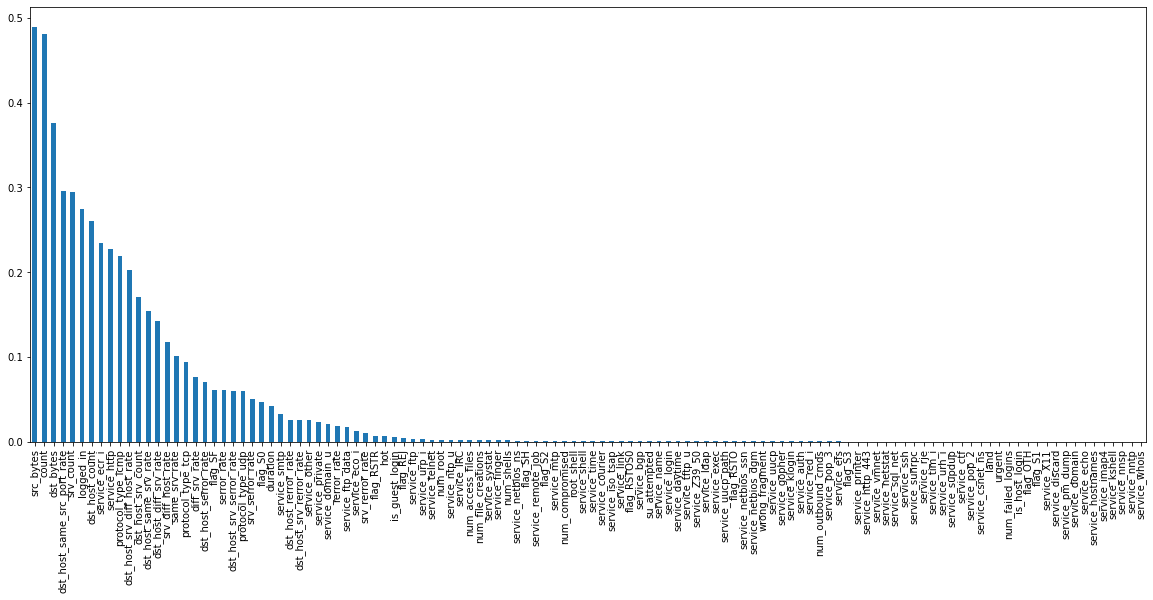

In [14]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [15]:
from sklearn.feature_selection import SelectKBest


In [16]:
sel_five_cols = SelectKBest(mutual_info_classif, k=27)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

Index(['duration', 'src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count',
       'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'flag_S0', 'flag_SF', 'service_ecr_i', 'service_http', 'service_smtp'],
      dtype='object')